# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. The formula suggests that we compute similarity for all words in one window (w), and sum them, repeating for 
  each this for each window in the batch (first loop). The result (x) is how well our model describes similarity
  between cooccuring words. The second loop computes similarity between words from different windows (b). This
  part of loss (y) serves as replacement for negative samples.
  2. We could also compute the similarity not between all the words in the window, but only between the center word
  and the surrounding words. Probably, this would yield more word2vec-like results.
  1. Probably yes - we just need to compute similarity between the center word and the sum of the words around it.
  The y term would be used to replace the negative sampling approximation of softmax.
  1. Yes, it does. For batch-transpose the center word should be sampled randomly, while for the vanilla negative
  sampling it is not strictly required. 

## Vanilla negative sampling 

In [1]:
import torch
import numpy as np
from torch import nn
import torch.autograd

from tqdm import tqdm_notebook as tqdm  # because I love progress bars
import time
from typing import List, Iterable, Tuple

from utils import SkipGramNSDataGen, Vocab, preprocess

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
device = torch.device("cuda")

In [3]:
with open("text8/text8", encoding="utf-8") as f:
    tokens = preprocess(f.read())

In [4]:
# training parameters go here
vocab_size = 30000
window_size = 5
emb_size = 150
batch_size = 256
n_epochs = 3
ns = 5
constant = 3/4

lr = 3e-4

In [5]:
vocab = Vocab(vocab_size, constant)

In [6]:
vocab.build([tokens])

In [7]:
class SGNS(nn.Module):
    """
    Implementing skipgram with negative sampling
    """
    def __init__(self, vocab_size: int, emb_size: int, device):
        super(SGNS, self).__init__()
        self.emb = nn.Linear(vocab_size + 1, emb_size)
        self.out = nn.Linear(emb_size, vocab_size + 1)
#         self.loss = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.device = device
    
    def forward(self, center, contandneg):
        # words predicted by center word
        center_pred = self.out(self.emb(center))
        # follow along the batch axis and get logits at contandneg positions
        to_update = torch.gather(center_pred, 1, contandneg)
        # the context word always have the index zero in `contandneg`
        # y = torch.zeros(contandneg.size(0), dtype=torch.long).to(self.device)
        # loss = self.loss(to_update, y)
        to_update = self.sigmoid(to_update)
        #      first term                   second term        1-sig(x) = sig(-x)       omitting dim leads to silent 
        #                                                                               errors due to broadcasting
        loss = torch.log(to_update[:, 0]) + torch.sum(torch.log(-to_update[:, 1:] + 1), dim=1)
        return -torch.mean(loss)

In [8]:
data = SkipGramNSDataGen([vocab.numericalize(tokens)], window_size, vocab.normalized_counts, ns)

In [9]:
model = SGNS(vocab_size, 150, device)

In [10]:
model.to(device)

SGNS(
  (emb): Linear(in_features=30001, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=30001, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
def epoch(model: nn.Module, 
          data: SkipGramNSDataGen, 
          loss_history: List, 
          optimizer, 
          device, 
          bs=128, 
          report_every=3000):
    """
    Run one epoch of training the `model` on `data`.
    Loss values for plotting are saved in `loss_history`.
    Average batch loss is printed every `report_every` epochs.
    """
    start = time.time()
    running_loss = list()
    for i, (x, y) in enumerate(tqdm(data.iter_batch(bs))):
        optimizer.zero_grad()
        x_onehot = torch.zeros((len(x), vocab_size + 1), dtype=torch.float)
        for b_i, x_i in enumerate(x):
            x_onehot[b_i, x_i] = 1
        x = x_onehot.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        loss = model.forward(x, y)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.detach().item())
        if (i + 1) % report_every == 0:
            avg_loss = sum(running_loss) / len(running_loss)
            print("Step {}, loss: {}".format(i + 1, avg_loss))
            loss_history.append(avg_loss)
            running_loss = list()
    print("Done. Time: {}. Loss: {}.".format(time.time() - start, sum(running_loss) / len(running_loss)))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
loss_history = list()

In [14]:
for i in range(n_epochs):
    print("Epoch", i)
    epoch(model, data, loss_history, optimizer, device, bs=batch_size, report_every=2000)

Epoch 0


Step 2000, loss: 2.7915591760873792
Step 4000, loss: 2.4108881875276564
Step 6000, loss: 2.3949430482387544
Step 8000, loss: 2.3892552652359007
Step 10000, loss: 2.3833437558412554
Step 12000, loss: 2.380354591012001
Step 14000, loss: 2.3745902700424195
Step 16000, loss: 2.370616886973381
Step 18000, loss: 2.3652150166034698
Step 20000, loss: 2.3617140822410585
Step 22000, loss: 2.35632006752491
Step 24000, loss: 2.3538295525312423
Step 26000, loss: 2.3493160510063174
Step 28000, loss: 2.345530328154564
Step 30000, loss: 2.342065575480461
Step 32000, loss: 2.336697664856911
Step 34000, loss: 2.3339280585050584
Step 36000, loss: 2.3299355165958406
Step 38000, loss: 2.33029128241539
Step 40000, loss: 2.3250407695770265
Step 42000, loss: 2.3221449429988863
Step 44000, loss: 2.321032302618027
Step 46000, loss: 2.3198576530218125
Step 48000, loss: 2.316960144519806
Step 50000, loss: 2.3132029284238813
Step 52000, loss: 2.3111283715963364
Step 54000, loss: 2.3089063767194746
Step 56000, loss

Step 2000, loss: 2.290913743853569
Step 4000, loss: 2.29030904173851
Step 6000, loss: 2.2898969995975493
Step 8000, loss: 2.2883396252393724
Step 10000, loss: 2.28869812977314
Step 12000, loss: 2.2856625725030897
Step 14000, loss: 2.284964625597
Step 16000, loss: 2.284331787109375
Step 18000, loss: 2.282239538192749
Step 20000, loss: 2.280949021935463
Step 22000, loss: 2.278829752802849
Step 24000, loss: 2.278508037447929
Step 26000, loss: 2.2768294900655746
Step 28000, loss: 2.278568935751915
Step 30000, loss: 2.276690973997116
Step 32000, loss: 2.2766688262224197
Step 34000, loss: 2.2744799351692198
Step 36000, loss: 2.2729126719236374
Step 38000, loss: 2.2704993832111358
Step 40000, loss: 2.26982146859169
Step 42000, loss: 2.2719340145587923
Step 44000, loss: 2.269513376235962
Step 46000, loss: 2.2668418447971344
Step 48000, loss: 2.2665688219070437
Step 50000, loss: 2.2679841047525406
Step 52000, loss: 2.265223569393158
Step 54000, loss: 2.2662303686141967
Step 56000, loss: 2.26325

Step 2000, loss: 2.257563637971878
Step 4000, loss: 2.2550675698518754
Step 6000, loss: 2.2543548448085784
Step 8000, loss: 2.2562629623413084
Step 10000, loss: 2.2550879188776016
Step 12000, loss: 2.2549125769138336
Step 14000, loss: 2.2553622891902925
Step 16000, loss: 2.253268372416496
Step 18000, loss: 2.2528255429267885
Step 20000, loss: 2.2523121987581254
Step 22000, loss: 2.2539160619974137
Step 24000, loss: 2.2502637412548063
Step 26000, loss: 2.2508068500757217
Step 28000, loss: 2.2522060800790786
Step 30000, loss: 2.2499312143325807
Step 32000, loss: 2.248297651171684
Step 34000, loss: 2.2506138634681703
Step 36000, loss: 2.2512643365859986
Step 38000, loss: 2.2470673407316206
Step 40000, loss: 2.2483202650547027
Step 42000, loss: 2.2492843034267427
Step 44000, loss: 2.246729296326637
Step 46000, loss: 2.2470721468925476
Step 48000, loss: 2.2482539019584658
Step 50000, loss: 2.2482523021697998
Step 52000, loss: 2.247476205945015
Step 54000, loss: 2.246122973442078
Step 56000,

In [32]:
torch.save(model.state_dict(), "task_5.pth")

### 1. Trained word vectors 

With almost 4 hours for three epochs, this one was the longest to train, probably because of one-hot encoding all the vectors.

In [26]:
def get_embeddings(model: nn.Module, mode: str="first"):
    """
    Get the embeddings from the model. Supported modes are:
    `first`: embeddings from the first layer
    `second`: embeddings from the (surprise!) second layer
    `average`: embeddings from both the layers, averaged.
    """
    if mode == "first":
        return model.emb.weight.data.clone().detach().t().cpu().numpy()
    if mode == "second":
        return model.out.weight.data.clone().detach().cpu().numpy()
    if mode == "average":
        return (model.emb.weight.data.clone().detach().t().cpu().numpy() + \
            model.out.weight.data.clone().detach().cpu().numpy()) / 2

In [34]:
embeddings = get_embeddings(model, "average")

In [35]:
embeddings.shape

(30001, 150)

In [36]:
import pickle

with open("vocab_ns.pkl", "wb") as f:
    pickle.dump(vocab.itos, f)

### 2. Plotted loss

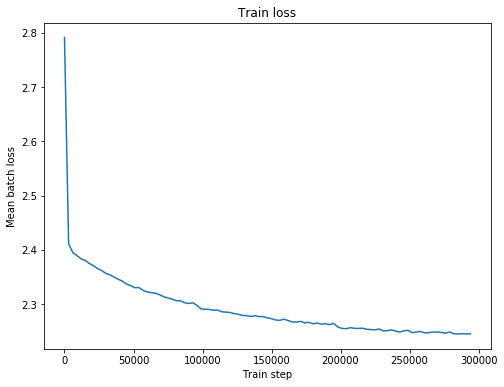

In [37]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=[3000*i for i in range(len(loss_history))], y=loss_history)
plt.title("Train loss")
plt.ylabel("Mean batch loss")
plt.xlabel("Train step")
plt.show()

### 3. Function to map token to corresponding word vector

In [42]:
def get_vector(word: str, vocab: Vocab, embeddings: np.array):
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    return vec

In [39]:
get_vector("russia", vocab, embeddings).shape

(150,)

### 4. Beautiful visualizations (PCE, T-SNE)

In [124]:
def most_similar(word: str, vocab: Vocab, embeddings: np.array, n_similar: int) -> List[Tuple[str, int]]:
    assert word in vocab.stoi, "Word is not in the vocabulary"
    i = vocab.stoi[word]
    vec = embeddings[i]
    # cosine similarity measure:
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec))))
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

In [44]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(2)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [45]:
def visualize(embeddings, vocab, words, num_neihgbors, pca):
    clusters = list()
    for word in words:
        clusters.append(most_similar(word, vocab, embeddings, num_neihgbors))

    vectors, labels, sims, hues = list(), list(), list(), list()
    for i, cluster in enumerate(clusters):
        for w, s in cluster:
            vectors.append(get_vector(w, vocab, embeddings))
            labels.append(w)
            sims.append(s)
            hues.append(i)

    transformed = pca.transform(np.stack(vectors))
    
    return transformed[:, 0], transformed[:, 1], labels, sims, hues

In [50]:
words_to_vis = ["cat", "russia", "scientist"]

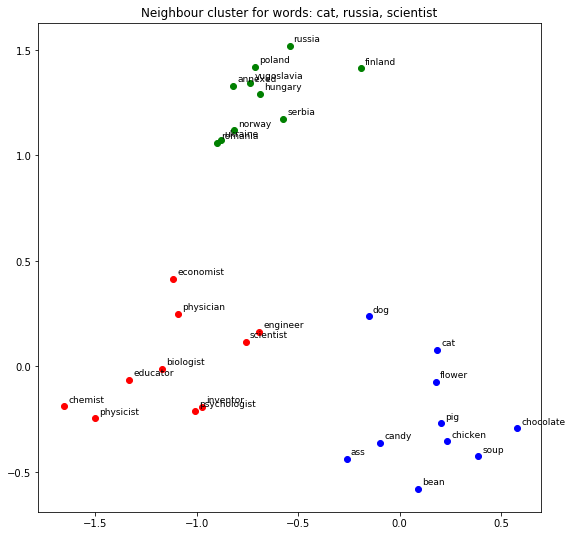

In [51]:
x, y, labels, sims, hues = visualize(embeddings, vocab, words_to_vis, 10, pca)

plt.figure(figsize=(9, 9))
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # this is how many clusters you can get
offs = 0.02

for i in range(len(labels)):
    plt.scatter(x[i], y[i], c=plt_colors[hues[i]])
    plt.text(x[i] + offs, y[i] + offs, labels[i], fontsize=9)

plt.title(f"Neighbour cluster for words: {', '.join(words_to_vis)}")
plt.show()

We see much better cluster than with naive skip-gram. I hope `ass` is the animal with long ears, not a body part.

### 5. Qualitative evaluations of word vectors: nearest neighbors, word analogies

In [46]:
def most_similar_to_vec(vec, vocab, embeddings, n_similar):
    sims = embeddings @ vec.T \
        / (np.sqrt(np.sum(np.square(embeddings), axis=1)) \
           * np.sqrt(np.sum(np.square(vec)))) 
    i_to_sim = zip(vocab.itos, sims)
    words_by_sim = sorted(i_to_sim, key=lambda x: x[1], reverse=True)
    return list(words_by_sim)[:n_similar]

def solve_analogy(embeddings: np.ndarray, vocab: Vocab, task: List[str]) -> Tuple[str, float]:
    """
    Return the word d from `a to b is like c to d`, given a, b, c in the task list
    """
    indices = [vocab.stoi[w] for w in task]
    vectors = embeddings[indices]
    query = vectors[1] - vectors[0] + vectors [2]
    closest = most_similar_to_vec(query, vocab, embeddings, 4)
    for c in closest:
        if c[0] not in task:
            return c

#### Nearest neighbours 

In [54]:
most_similar("russia", vocab, embeddings, 10)

[('russia', 0.99999994),
 ('ukraine', 0.8789142),
 ('romania', 0.8767851),
 ('poland', 0.8694205),
 ('annexed', 0.84688973),
 ('hungary', 0.8465466),
 ('finland', 0.8426758),
 ('serbia', 0.83980036),
 ('norway', 0.8376435),
 ('yugoslavia', 0.83340967)]

In [55]:
most_similar("table", vocab, embeddings, 10)

[('table', 1.0),
 ('periodic', 0.83922595),
 ('hash', 0.779346),
 ('tables', 0.76496273),
 ('item', 0.7644561),
 ('specifies', 0.75572157),
 ('header', 0.7512016),
 ('diagram', 0.749897),
 ('encoded', 0.7468182),
 ('sorted', 0.74515986)]

In [56]:
most_similar("mars", vocab, embeddings, 10)

[('mars', 1.0),
 ('planet', 0.83834857),
 ('jupiter', 0.831834),
 ('venus', 0.82456344),
 ('spacecraft', 0.78867304),
 ('moons', 0.7869203),
 ('probe', 0.78160673),
 ('saturn', 0.7763427),
 ('moon', 0.77199817),
 ('voyager', 0.77055)]

In [57]:
most_similar("screen", vocab, embeddings, 10)

[('screen', 1.0),
 ('camera', 0.8435133),
 ('disc', 0.82534087),
 ('button', 0.8176682),
 ('punch', 0.8165438),
 ('buttons', 0.8149779),
 ('display', 0.8144325),
 ('dvds', 0.8102629),
 ('cameras', 0.80853915),
 ('screens', 0.80549204)]

#### Word analogies 

In [60]:
task = ["paris", "france", "moscow"]
solve_analogy(embeddings, vocab, task)

('russia', 0.82764703)

In [89]:
task = ["good", "better", "bad"]
solve_analogy(embeddings, vocab, task)

('worse', 0.80203146)

### Extra: intrinsic evaluation with Google analogies 

In [47]:
with open("questions-words.txt", encoding="utf-8") as f:
    pairs = f.read().strip().lower().split("\n")

In [91]:
from collections import defaultdict
tasks = defaultdict(list)

current_task = ""
for line in pairs:
    line = line.strip()
    if line.startswith(":"):
        current_task = line
    else:
        tasks[current_task].append(line.split(" "))

In [92]:
stats = dict()
for task in tasks:
    stats[task] = {"total": len(tasks[task]), "done": 0, "not_found": 0}
    for t in tasks[task]:
        try:
            res, _ = solve_analogy(embeddings, vocab, t[:3])
            if res == t[3]:
                stats[task]["done"] += 1
        except KeyError as e:
            stats[task]["not_found"] += 1# some of the words are not found in the vocab, so we don't get a point

In [93]:
stats

{': capital-common-countries': {'total': 506, 'done': 86, 'not_found': 0},
 ': capital-world': {'total': 4524, 'done': 128, 'not_found': 3072},
 ': currency': {'total': 866, 'done': 11, 'not_found': 377},
 ': city-in-state': {'total': 2467, 'done': 201, 'not_found': 896},
 ': family': {'total': 506, 'done': 116, 'not_found': 164},
 ': gram1-adjective-to-adverb': {'total': 992, 'done': 19, 'not_found': 124},
 ': gram2-opposite': {'total': 812, 'done': 22, 'not_found': 326},
 ': gram3-comparative': {'total': 1332, 'done': 231, 'not_found': 36},
 ': gram4-superlative': {'total': 1122, 'done': 31, 'not_found': 386},
 ': gram5-present-participle': {'total': 1056, 'done': 106, 'not_found': 32},
 ': gram6-nationality-adjective': {'total': 1599,
  'done': 427,
  'not_found': 117},
 ': gram7-past-tense': {'total': 1560, 'done': 102, 'not_found': 117},
 ': gram8-plural': {'total': 1332, 'done': 192, 'not_found': 244},
 ': gram9-plural-verbs': {'total': 870, 'done': 52, 'not_found': 116}}

In [94]:
done = 0
total = 0
for stat in stats:
    name = stat
    stat = stats[name]
    acc = stat["done"] / stat["total"]
    done += stat["done"]
    total += stat["total"]
    print(f"{name}: {acc: .2%}")
print(f"Total: {done/total: .2%}")

: capital-common-countries:  17.00%
: capital-world:  2.83%
: currency:  1.27%
: city-in-state:  8.15%
: family:  22.92%
: gram1-adjective-to-adverb:  1.92%
: gram2-opposite:  2.71%
: gram3-comparative:  17.34%
: gram4-superlative:  2.76%
: gram5-present-participle:  10.04%
: gram6-nationality-adjective:  26.70%
: gram7-past-tense:  6.54%
: gram8-plural:  14.41%
: gram9-plural-verbs:  5.98%
Total:  8.82%


## Batch transpose trick 

For batch-transpose trick, we need a somewhat modified batcher. While in previous batchers I assumed that from each window we sample one context word, in this case we will need to do something we would do with CBOW.

In [170]:
from utils import SkipGramBTTDataGen
import math

In [330]:
class SGBTT(nn.Module):
    """
    Implementing skipgram with batch transpose trick
    """
    def __init__(self, vocab_size: int, emb_size: int, ws: int, device):
        super(SGBTT, self).__init__()
        # no more one-hot vectors!
        self.emb = nn.Embedding(
            vocab_size + 1, 
            emb_size
        )
        nn.init.kaiming_uniform_(self.emb.weight, a=math.sqrt(5))
        self.ws = ws
        self.device = device
    
    def forward(self, batch):
        batch = self.emb(batch)
        norm = batch.norm(p=2, dim=2, keepdim=True).detach()
        batch = batch.div(norm)
        #   xs = list()  
        #   for batch_idx in range(len(batch)):
        #       w = batch[batch_idx, :, :]
        #       xs.append(torch.sum(w.t() @ w - 1.))

        #   ys = list()
        #   for window_idx in range(self.ws * 2 + 1):
        #       b = batch[:, window_idx, :]
        #       ys.append(torch.sum(b.t() @ b))

        # loss = -torch.sum(torch.cat(xs)) + torch.sum(torch.cat(ys))
        
        # LETS VECTORIZZE
        x = (torch.bmm(batch, torch.transpose(batch, 1, 2)) - 1)
        y = torch.bmm(
            torch.transpose(batch, 0, 1),
            torch.transpose(torch.transpose(batch, 0, 1), 1, 2)
        )
        
        loss = -torch.sum(x) + torch.sum(y)
        return loss

In [338]:
# Parameters should be tweaked for this model to perform better
vocab_size = 30000
window_size = 5
emb_size = 150
batch_size = 64
n_epochs = 3
ns = 5
constant = 3/4

lr = 3e-4

In [288]:
vocab = Vocab(vocab_size, constant)
vocab.build([tokens])

In [289]:
data = SkipGramBTTDataGen([vocab.numericalize(tokens)], window_size)

In [339]:
model = SGBTT(vocab_size, 150, window_size, device)

In [340]:
model.to(device)

SGBTT(
  (emb): Embedding(30001, 150)
)

In [341]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [342]:
loss_history = list()

In [343]:
def epoch(model: nn.Module, 
          data: SkipGramBTTDataGen, 
          loss_history: List, 
          optimizer, 
          device, 
          bs=128, 
          report_every=3000):
    """
    Run one epoch of training the `model` on `data`.
    Loss values for plotting are saved in `loss_history`.
    Average batch loss is printed every `report_every` epochs.
    """
    start = time.time()
    running_loss = list()
    for i, batch in enumerate(tqdm(data.iter_batch(bs))):
        optimizer.zero_grad()
        batch = torch.tensor(batch, dtype=torch.long).to(device)
        loss = model.forward(batch)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.detach().item())
        if (i + 1) % report_every == 0:
            avg_loss = sum(running_loss) / len(running_loss)
            print("Step {}, loss: {}".format(i + 1, avg_loss))
            loss_history.append(avg_loss)
            running_loss = list()
    print("Done. Time: {}. Loss: {}.".format(time.time() - start, sum(running_loss) / len(running_loss)))

In [344]:
for i in range(n_epochs):
    print("Epoch", i)
    epoch(model, data, loss_history, optimizer, device, bs=batch_size, report_every=8000)

Epoch 0


Step 8000, loss: 6922.531254089356
Step 16000, loss: 6415.809563720703
Step 24000, loss: 6253.110595336914
Step 32000, loss: 6193.8762189331055
Step 40000, loss: 6164.222135864258
Step 48000, loss: 6135.113304992676
Step 56000, loss: 6121.161873779297
Step 64000, loss: 6113.99996472168
Step 72000, loss: 6113.067741333008
Step 80000, loss: 6094.556719543457
Step 88000, loss: 6098.258326660156
Step 96000, loss: 6091.715161682129
Step 104000, loss: 6090.332387145996
Step 112000, loss: 6087.313057983399
Step 120000, loss: 6092.947467346192
Step 128000, loss: 6093.183935119629
Step 136000, loss: 6081.476648193359
Step 144000, loss: 6090.477923339844
Step 152000, loss: 6081.780208129883
Step 160000, loss: 6086.066282897949
Step 168000, loss: 6081.645021606445
Step 176000, loss: 6079.493147705078
Step 184000, loss: 6082.31750189209
Step 192000, loss: 6084.247570007325
Step 200000, loss: 6085.7657890625
Step 208000, loss: 6085.722837524414
Step 216000, loss: 6079.287731018067
Step 224000, loss

Step 8000, loss: 6066.711372314453
Step 16000, loss: 6076.442223632813
Step 24000, loss: 6071.476499633789
Step 32000, loss: 6080.792936401367
Step 40000, loss: 6068.637865539551
Step 48000, loss: 6071.692631896973
Step 56000, loss: 6073.202460083008
Step 64000, loss: 6069.693323120117
Step 72000, loss: 6074.663681396484
Step 80000, loss: 6072.76906427002
Step 88000, loss: 6077.332327026367
Step 96000, loss: 6067.314661987305
Step 104000, loss: 6075.923491455078
Step 112000, loss: 6074.827698303223
Step 120000, loss: 6073.814983215332
Step 128000, loss: 6075.825471191406
Step 136000, loss: 6074.569455627441
Step 144000, loss: 6072.854779846191
Step 152000, loss: 6071.682022766114
Step 160000, loss: 6076.613666564941
Step 168000, loss: 6077.86665435791
Step 176000, loss: 6075.536215942383
Step 184000, loss: 6071.18246069336
Step 192000, loss: 6074.959123474121
Step 200000, loss: 6075.051067993164
Step 208000, loss: 6070.106549682617
Step 216000, loss: 6081.5381510009765
Step 224000, los

Step 8000, loss: 6076.728727905273
Step 16000, loss: 6070.622336242675
Step 24000, loss: 6073.977973388672
Step 32000, loss: 6074.884422607422
Step 40000, loss: 6081.840183288574
Step 48000, loss: 6069.668176330566
Step 56000, loss: 6069.002945007324
Step 64000, loss: 6077.379930297851
Step 72000, loss: 6080.999819641113
Step 80000, loss: 6076.383961730957
Step 88000, loss: 6079.862813903808
Step 96000, loss: 6076.913900024414
Step 104000, loss: 6074.395930297852
Step 112000, loss: 6074.927205871582
Step 120000, loss: 6074.660599609375
Step 128000, loss: 6071.054357421875
Step 136000, loss: 6072.269321350098
Step 144000, loss: 6060.390648376465
Step 152000, loss: 6064.5641439208985
Step 160000, loss: 6071.643696960449
Step 168000, loss: 6075.355172668457
Step 176000, loss: 6075.119246948242
Step 184000, loss: 6071.058132324219
Step 192000, loss: 6075.051375122071
Step 200000, loss: 6078.182665710449
Step 208000, loss: 6071.864989379883
Step 216000, loss: 6065.9570106811525
Step 224000,

### 1. Trained word vectors 

Time: an hour and a half.

In [345]:
embeddings = model.emb.weight.detach().cpu().numpy()

In [346]:
most_similar("russia", vocab, embeddings, 10)

[('russia', 1.0000001),
 ('germany', 0.9992042),
 ('pakistani', 0.9986607),
 ('poland', 0.99860096),
 ('hungary', 0.998516),
 ('spain', 0.99809176),
 ('austria', 0.9980056),
 ('cdu', 0.9978891),
 ('rhodesia', 0.99786663),
 ('tripoli', 0.99771535)]

In [347]:
embeddings.shape

(30001, 150)

### 2. Plotted loss

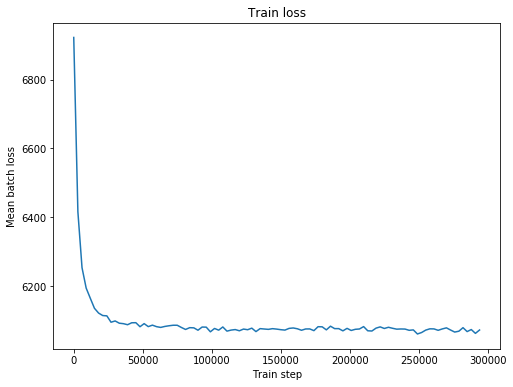

In [348]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=[3000*i for i in range(len(loss_history))], y=loss_history)
plt.title("Train loss")
plt.ylabel("Mean batch loss")
plt.xlabel("Train step")
plt.show()

### 3. Function to map token to corresponding word vector

In [349]:
get_vector("russia", vocab, embeddings).shape

(150,)

### 4. Beautiful visualizations (PCE, T-SNE)

In [350]:
pca = PCA(2)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [351]:
embs_pca = pca.transform(embeddings)

In [352]:
words_to_vis = ["london", "law", "game"]

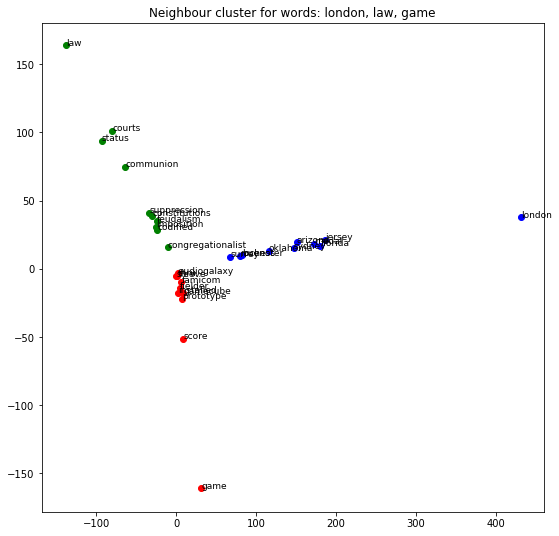

In [353]:
x, y, labels, sims, hues = visualize(embeddings, vocab, words_to_vis, 10, pca)

plt.figure(figsize=(9, 9))
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # this is how many clusters you can get
offs = 0.02

for i in range(len(labels)):
    plt.scatter(x[i], y[i], c=plt_colors[hues[i]])
    plt.text(x[i] + offs, y[i] + offs, labels[i], fontsize=9)

plt.title(f"Neighbour cluster for words: {', '.join(words_to_vis)}")
plt.show()

### 5. Qualitative evaluations of word vectors: nearest neighbors, word analogies

#### Nearest neighbours 

In [354]:
most_similar("russia", vocab, embeddings, 10)

[('russia', 1.0000001),
 ('germany', 0.9992042),
 ('pakistani', 0.9986607),
 ('poland', 0.99860096),
 ('hungary', 0.998516),
 ('spain', 0.99809176),
 ('austria', 0.9980056),
 ('cdu', 0.9978891),
 ('rhodesia', 0.99786663),
 ('tripoli', 0.99771535)]

In [355]:
most_similar("table", vocab, embeddings, 10)

[('table', 1.0),
 ('logarithm', 0.9973896),
 ('projective', 0.99694586),
 ('norm', 0.9967678),
 ('projection', 0.99654526),
 ('hyperbola', 0.9963104),
 ('autocorrelation', 0.99620676),
 ('diagram', 0.99600065),
 ('decibel', 0.99595535),
 ('specifies', 0.99594396)]

In [356]:
most_similar("war", vocab, embeddings, 10)

[('war', 1.0),
 ('stalingrad', 0.99868745),
 ('republican', 0.99789506),
 ('confederate', 0.99785304),
 ('army', 0.9978402),
 ('chiefs', 0.9973371),
 ('armistice', 0.9967854),
 ('brokered', 0.9964058),
 ('senators', 0.9960154),
 ('revolutionary', 0.99597526)]

In [357]:
most_similar("data", vocab, embeddings, 10)

[('data', 0.9999999),
 ('bandwidth', 0.99904597),
 ('supercomputers', 0.9986943),
 ('sequential', 0.99860704),
 ('infrared', 0.9983736),
 ('relational', 0.9983091),
 ('addressing', 0.9981318),
 ('lcds', 0.99798375),
 ('storage', 0.99788916),
 ('storing', 0.99774826)]

#### Word analogies 

In [364]:
task = ["beijing", "china", "paris"]
solve_analogy(embeddings, vocab, task)

('france', 0.999592)

### Extra: intrinsic evaluation with Google analogies 

In [359]:
from collections import defaultdict
tasks = defaultdict(list)

current_task = ""
for line in pairs:
    line = line.strip()
    if line.startswith(":"):
        current_task = line
    else:
        tasks[current_task].append(line.split(" "))

In [366]:
stats = dict()
for task in tasks:
    stats[task] = {"total": len(tasks[task]), "done": 0, "not_found": 0}
    for t in tasks[task]:
        try:
            res, _ = solve_analogy(embeddings, vocab, t[:3])
            if res == t[3]:
                stats[task]["done"] += 1
        except KeyError as e:
            stats[task]["not_found"] += 1# some of the words are not found in the vocab, so we don't get a point

In [367]:
stats

{': capital-common-countries': {'total': 506, 'done': 5, 'not_found': 0},
 ': capital-world': {'total': 4524, 'done': 17, 'not_found': 3072},
 ': currency': {'total': 866, 'done': 0, 'not_found': 377},
 ': city-in-state': {'total': 2467, 'done': 17, 'not_found': 896},
 ': family': {'total': 506, 'done': 6, 'not_found': 164},
 ': gram1-adjective-to-adverb': {'total': 992, 'done': 0, 'not_found': 124},
 ': gram2-opposite': {'total': 812, 'done': 0, 'not_found': 326},
 ': gram3-comparative': {'total': 1332, 'done': 9, 'not_found': 36},
 ': gram4-superlative': {'total': 1122, 'done': 1, 'not_found': 386},
 ': gram5-present-participle': {'total': 1056, 'done': 2, 'not_found': 32},
 ': gram6-nationality-adjective': {'total': 1599,
  'done': 17,
  'not_found': 117},
 ': gram7-past-tense': {'total': 1560, 'done': 7, 'not_found': 117},
 ': gram8-plural': {'total': 1332, 'done': 4, 'not_found': 244},
 ': gram9-plural-verbs': {'total': 870, 'done': 2, 'not_found': 116}}

In [368]:
done = 0
total = 0
for stat in stats:
    name = stat
    stat = stats[name]
    acc = stat["done"] / stat["total"]
    done += stat["done"]
    total += stat["total"]
    print(f"{name}: {acc: .2%}")
print(f"Total: {done/total: .2%}")

: capital-common-countries:  0.99%
: capital-world:  0.38%
: currency:  0.00%
: city-in-state:  0.69%
: family:  1.19%
: gram1-adjective-to-adverb:  0.00%
: gram2-opposite:  0.00%
: gram3-comparative:  0.68%
: gram4-superlative:  0.09%
: gram5-present-participle:  0.19%
: gram6-nationality-adjective:  1.06%
: gram7-past-tense:  0.45%
: gram8-plural:  0.30%
: gram9-plural-verbs:  0.23%
Total:  0.45%
